##### Now we train the model using train set and test it with the test set. Now , I will process the data with several classification algorithms. The models will be judged based on the following properties :
1. Accuracy  = Number of correct predictions / Total number of predictions.    
As our data set is highly imbalanced , accuracy cannot be a perfect measure to measure the performance of the model.  

2. Precision = Number of correct predictions in a class(Normal/Fraud) / Number of predicted labels in that class.  
That implies , Precision = True Positives / (True Positives + False Positives)   

3. Recall    = Number of correct predictions in a class(Normal/Fraud) / Number of actual labels in that class.   
That implies , Recall = True Positives / (True Positives + False Negatives)     
    
   Now , we develop a Precision-Recall trade off. So we use the F1 score , which strikes a balance between Precision and Recall.   

4. F1 Score  = Harmonic mean of precision and recall.   
That implies , F1 Score = True Positives / (True Positives + 1/2(False postives + False Negatives))  

   And we have two averaging techniques , macro avg(unweighted average) and weighted avg . We prefer macro avg as our dataset is imbalanced.

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier , ExtraTreesClassifier , AdaBoostClassifier , BaggingClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier

import time
from sklearn.metrics import accuracy_score , f1_score , precision_score , recall_score , confusion_matrix , precision_recall_curve

print('All imports done.')

All imports done.


In [2]:
X_train = pd.read_csv("C:/Users/prane/Downloads/Github/CREDIT-CARD-FRAUD-DETECTION/X_train.csv").to_numpy()
Y_train = pd.read_csv("C:/Users/prane/Downloads/Github/CREDIT-CARD-FRAUD-DETECTION/Y_train.csv").to_numpy().ravel()
X_test = pd.read_csv("C:/Users/prane/Downloads/Github/CREDIT-CARD-FRAUD-DETECTION/X_test.csv").to_numpy()  
Y_test = pd.read_csv("C:/Users/prane/Downloads/Github/CREDIT-CARD-FRAUD-DETECTION/Y_test.csv").to_numpy().ravel()

In [3]:
[[ X_train.shape , Y_train.shape ],[ X_test.shape , Y_test.shape ]]

[[(220530, 29), (220530,)], [(55133, 29), (55133,)]]

In [4]:
def confusion_matrix_plot(matrix):
    fig, axn = plt.subplots(nrows= 2 , ncols= 4 ,figsize= (24,10))
    l = ['Normal' , 'Fraud']

    for i, ax in enumerate(axn.flat):
        k = list(df['Model Name'])[i]
        sns.heatmap(matrix[k] , ax=ax , cmap="vlag" , annot=True , annot_kws= {'size':20} , fmt= 'd' ,
                    linewidths= .5 , xticklabels = l , yticklabels=l)
        ax.set_title(k,fontsize=15)

    fig.text(0.46, 0.046 , 'Predicted Label' , fontsize= 'xx-large')
    fig.text(0.09, 0.44 , 'Actual Label' , rotation= 'vertical' , fontsize= 'xx-large')

In [5]:
def prediction_maker(Y_hat,Y_test):
    precision, recall, thresholds = precision_recall_curve(Y_test, Y_hat)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore) 

    Y_pred_new = []
    for i in range(len(Y_hat)) : 
        if Y_hat[i] < thresholds[ix] :
            Y_pred_new.append(0)
        else :  
            Y_pred_new.append(1) 

    return Y_pred_new , thresholds[ix]

# Training the model with Classification algorithms and Analysing the results.

In [6]:
classifiers = {
    'Logistic' : 
        LogisticRegression(solver= 'liblinear' , max_iter= 1000 , random_state= 4) ,
    'Random Forest' : 
        RandomForestClassifier(criterion= 'gini' , max_samples= len(X_train) ,  random_state= 4) ,
    'Extra Trees' : 
        ExtraTreesClassifier(max_samples= len(X_train) , criterion= 'gini' , bootstrap= True , random_state= 4) ,
    'AdaBoost' : 
        AdaBoostClassifier(n_estimators= 150 , random_state= 4) ,
    'Bagging' : 
        BaggingClassifier(n_estimators= 20 , max_samples= len(X_train) , random_state= 4) ,
    'Decision Trees' : 
        DecisionTreeClassifier(criterion= 'gini' , random_state= 4) ,
    'XG Boost' : 
        XGBClassifier() ,
    'Hist GB Classifier' :
        HistGradientBoostingClassifier( learning_rate= 0.02 , random_state= 4),
}

cf_matrix = dict.fromkeys(classifiers.keys())
cf_matrix_new = dict.fromkeys(classifiers.keys())

In [7]:
table = {
    'Model Name' : [] ,
    'Run Time(in secs)' : [] ,
    'Threshold' : [] ,
    'Test set Accuracy' : [] ,
    'New Accuracy' : [] ,
    'Test set Precision' : [] ,
    'New Precision' : [] ,
    'Test set Recall' : [] ,
    'New Recall' : [] ,
    'Test set F1 Score' : [] ,
    'New F1 Score' : []
}

In [8]:
for name , clf in classifiers.items() :
    a = time.time()

    clf.fit(X_train,Y_train)
    Y_pred = clf.predict(X_test)

    b = time.time()

    table['Model Name'].append(name)
    table['Run Time(in secs)'].append(b-a)
    table['Test set Accuracy'].append(accuracy_score(Y_test , Y_pred))
    table['Test set Precision'].append(precision_score(Y_test , Y_pred , average= 'macro'))
    table['Test set Recall'].append(recall_score(Y_test , Y_pred , average= 'macro'))
    table['Test set F1 Score'].append(f1_score(Y_test , Y_pred , average= 'macro'))

    Y_hat = clf.predict_proba(X_test)[:,1]
    Y_pred_new , threshold = prediction_maker(Y_hat , Y_test)

    table['Threshold'].append(threshold)
    table['New Accuracy'].append(accuracy_score(Y_test , Y_pred_new))
    table['New Precision'].append(precision_score(Y_test , Y_pred_new , average= 'macro'))
    table['New Recall'].append(recall_score(Y_test , Y_pred_new , average= 'macro'))
    table['New F1 Score'].append(f1_score(Y_test , Y_pred_new , average= 'macro'))

    cf_matrix[name] = confusion_matrix(Y_test,Y_pred) 
    cf_matrix_new[name] = confusion_matrix(Y_test,Y_pred_new) 

In [9]:
df = pd.DataFrame(table) 
df = df.sort_values('Test set F1 Score' , ascending= False , ignore_index= True)
df[['Model Name','Run Time(in secs)','Test set Accuracy','Test set Precision','Test set Recall','Test set F1 Score']]

,Model Name,Run Time(in secs),Test set Accuracy,Test set Precision,Test set Recall,Test set F1 Score
0,XG Boost,31.387388,0.999692,0.992910,0.908037,0.946464
1,Random Forest,168.597284,0.999619,0.979003,0.896524,0.933867
2,Extra Trees,13.224018,0.999601,0.985326,0.885039,0.929387
3,Bagging,178.653208,0.999565,0.984875,0.873545,0.921969
4,Hist GB Classifier,3.861784,0.999547,0.971238,0.879274,0.920269
5,AdaBoost,145.777123,0.999420,0.923869,0.884948,0.903469
6,Decision Trees,12.269555,0.999293,0.883170,0.896361,0.889653
7,Logistic,1.757901,0.999111,0.939610,0.752819,0.820945


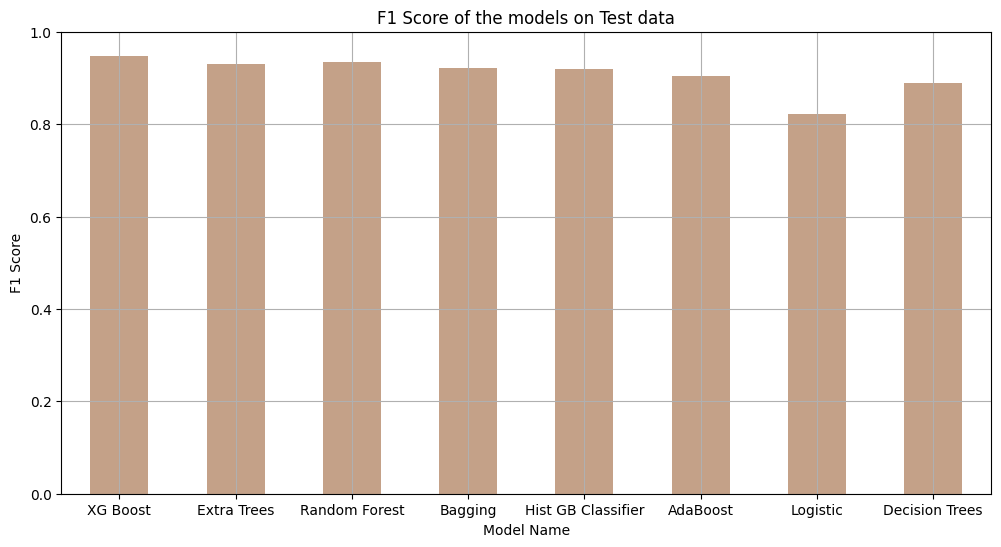

In [21]:
df.plot.bar(x="Model Name", y="Test set F1 Score", alpha=0.5, color= 'saddlebrown',
            title="F1 Score of the models on Test data", legend=False, figsize=[12,6], rot=0, grid=True, ylim=[0,1])
plt.ylabel("F1 Score")
plt.show()

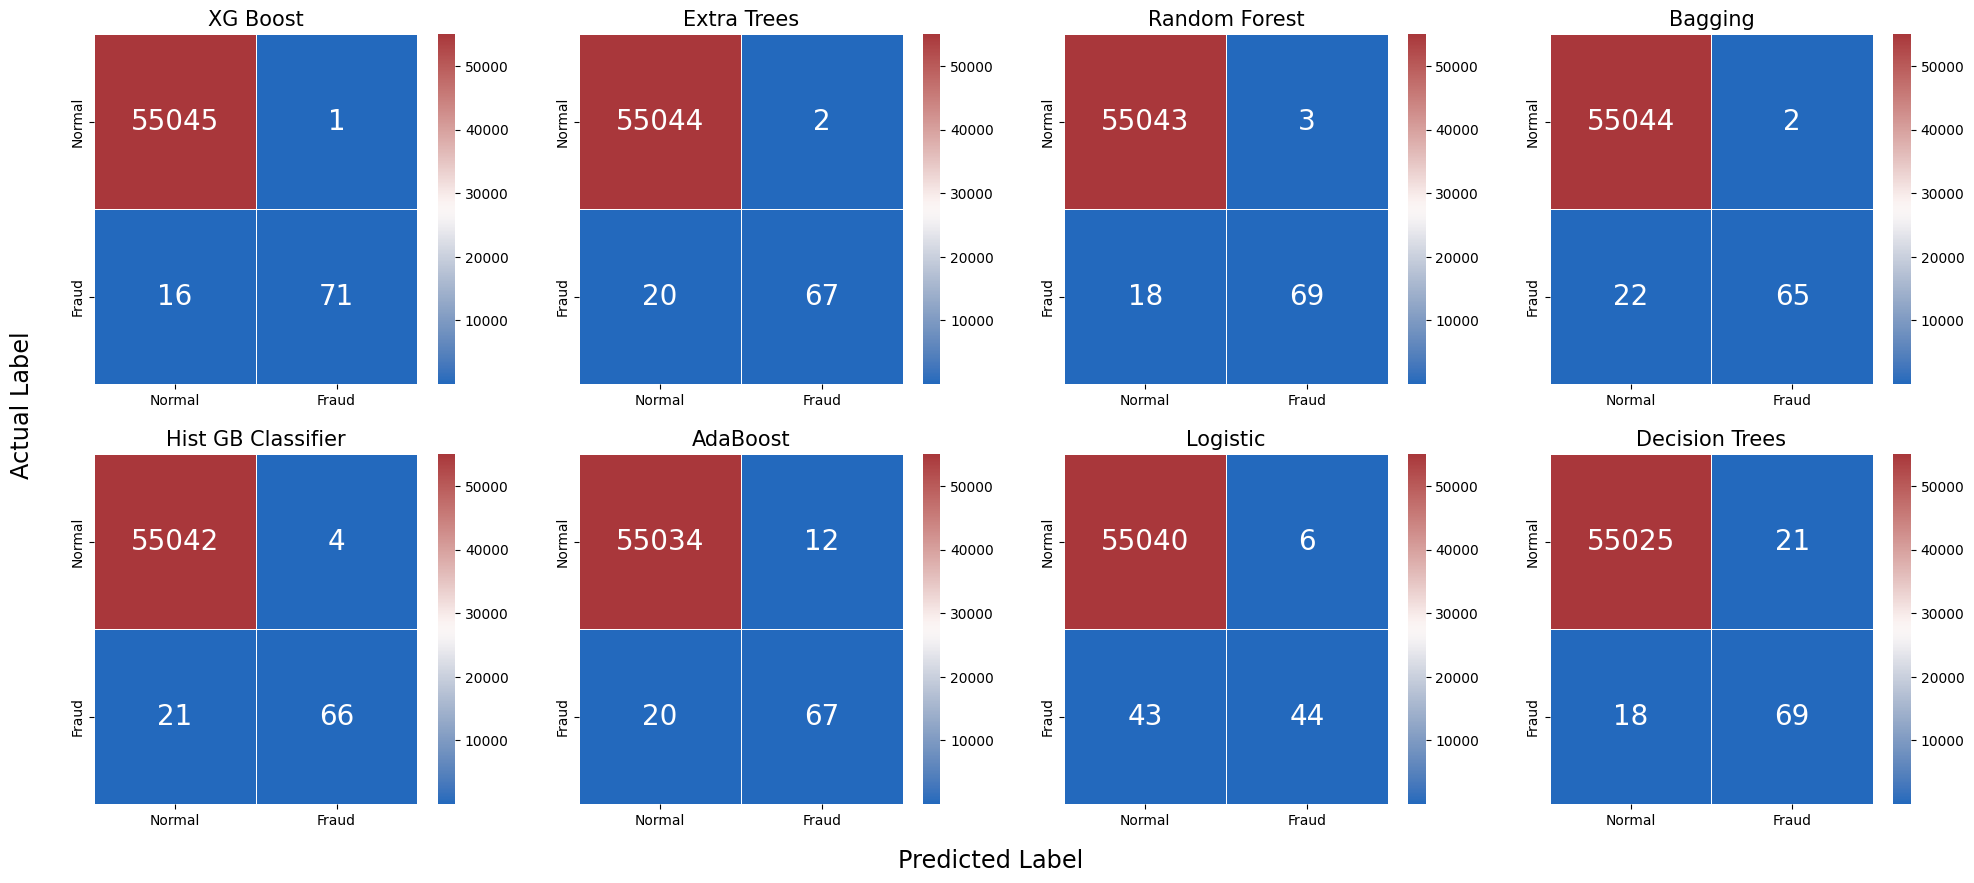

In [22]:
confusion_matrix_plot(cf_matrix)

In [23]:
df = pd.DataFrame(table) 
df = df.sort_values('New F1 Score' , ascending= False , ignore_index= True)
df[['Model Name','Threshold','New Accuracy','New Precision','New Recall','New F1 Score']]

,Model Name,Threshold,New Accuracy,New Precision,New Recall,New F1 Score
0,XG Boost,0.357713,0.999710,0.993014,0.913784,0.949927
1,Extra Trees,0.240000,0.999655,0.967822,0.919495,0.942338
2,Random Forest,0.290000,0.999637,0.967396,0.913748,0.938934
3,Bagging,0.500000,0.999601,0.985326,0.885039,0.929387
4,Hist GB Classifier,0.672414,0.999565,0.978070,0.879283,0.922968
5,AdaBoost,0.499424,0.999456,0.917502,0.907919,0.912654
6,Logistic,0.056961,0.999365,0.897573,0.902135,0.899841
7,Decision Trees,1.000000,0.999293,0.883170,0.896361,0.889653


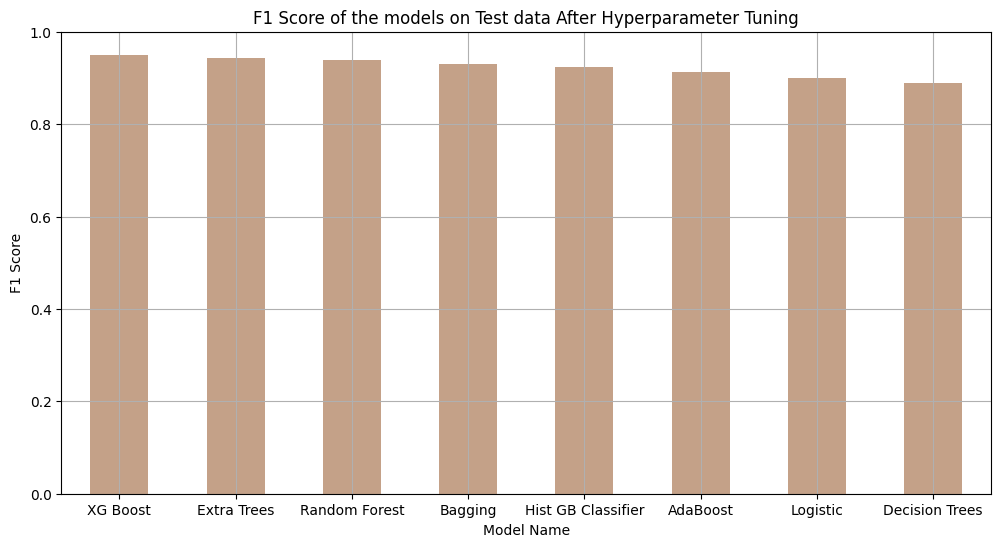

In [24]:
df.plot.bar(x="Model Name", y="New F1 Score", alpha=0.5, color= 'saddlebrown',
            title="F1 Score of the models on Test data After Hyperparameter Tuning", legend=False, figsize=[12,6], rot=0, grid=True, ylim=[0,1])
plt.ylabel("F1 Score")
plt.show()

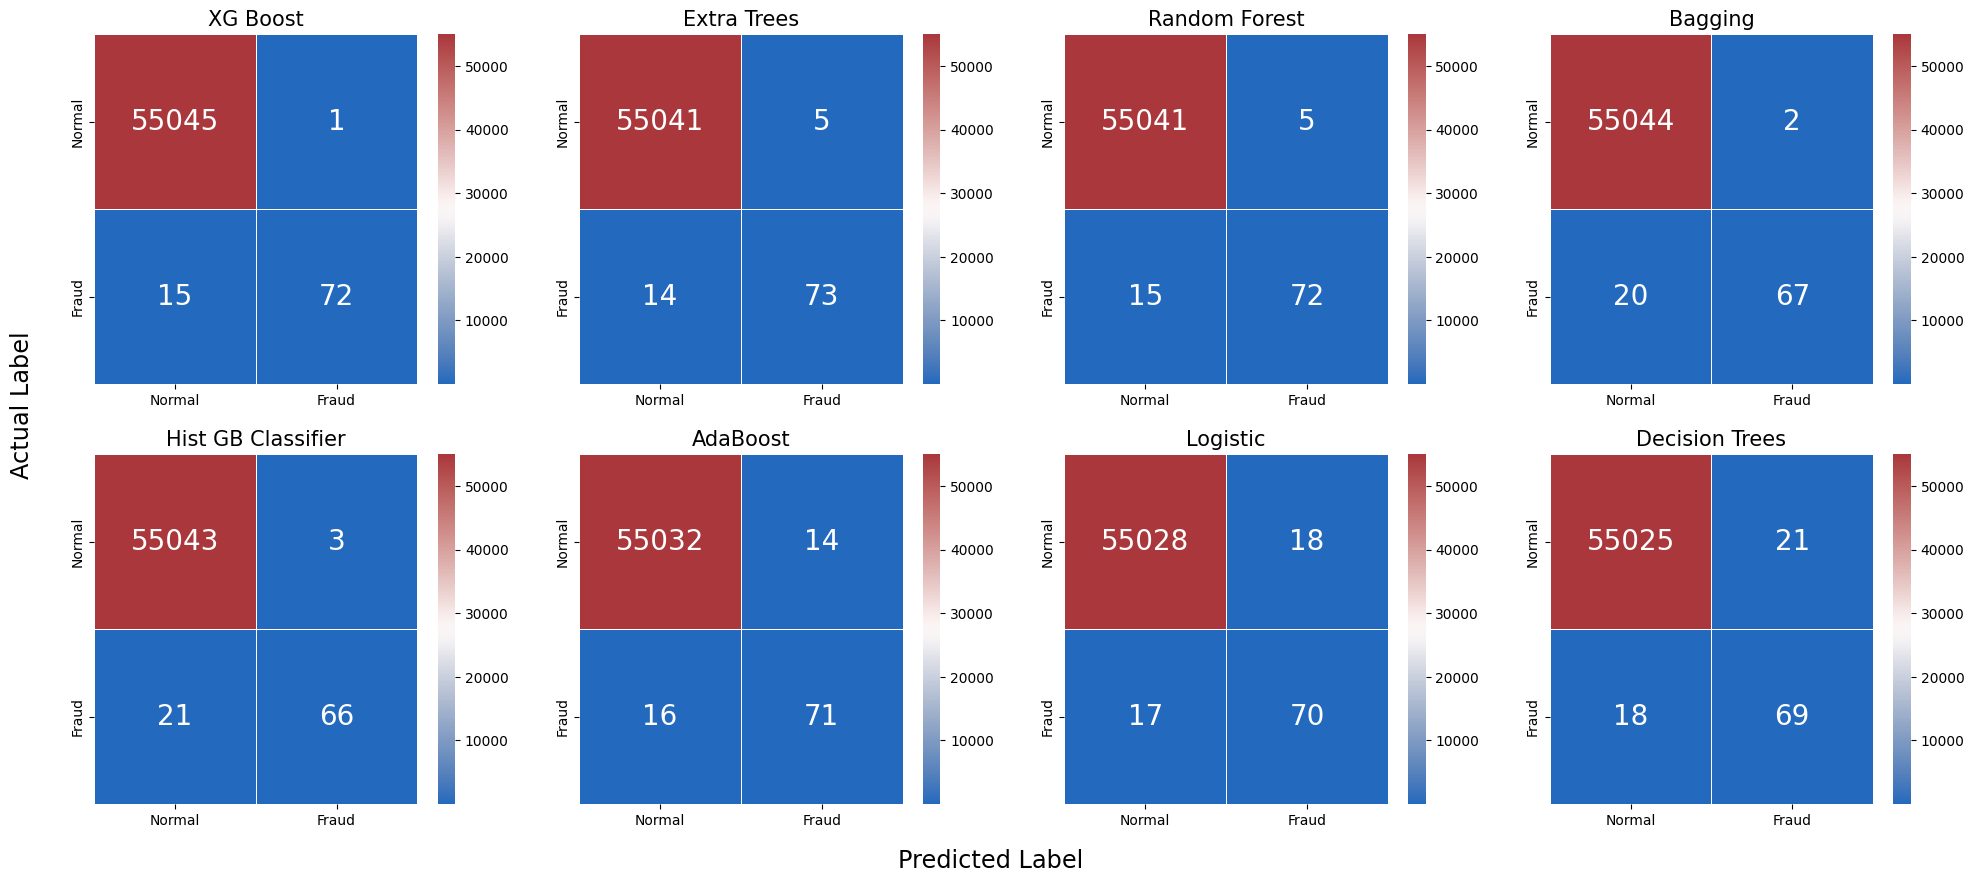

In [25]:
confusion_matrix_plot(cf_matrix_new)

##### From the above visualisations we can conclude that XGBoost is the best model for credit card fraud detection . 'XGBoost' has the highest accuracy , precision and recall as well. 

In [26]:
# Impact of changing the thresholds.
df[['Model Name','Test set F1 Score','New F1 Score']]

,Model Name,Test set F1 Score,New F1 Score
0,XG Boost,0.946464,0.949927
1,Extra Trees,0.929387,0.942338
2,Random Forest,0.933867,0.938934
3,Bagging,0.921969,0.929387
4,Hist GB Classifier,0.920269,0.922968
5,AdaBoost,0.903469,0.912654
6,Logistic,0.820945,0.899841
7,Decision Trees,0.889653,0.889653


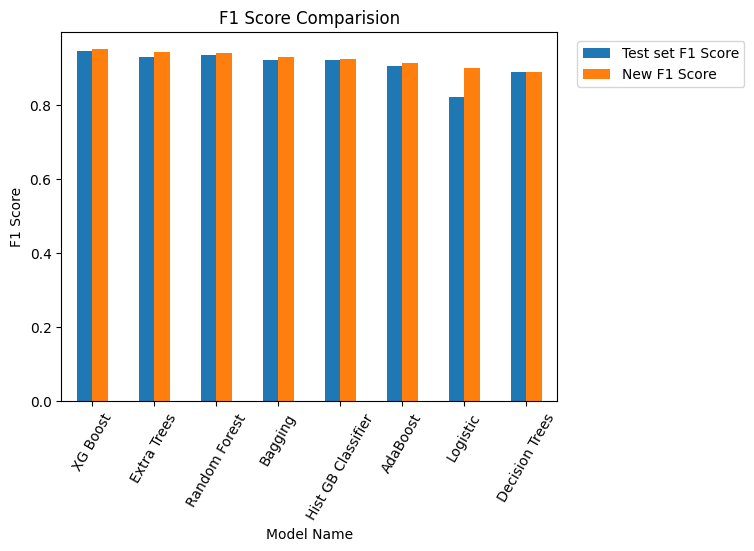

In [27]:
df[['Model Name','Test set F1 Score','New F1 Score']].plot(kind='bar')

plt.xticks(range(8),list(df['Model Name']),rotation= 60)
plt.title('F1 Score Comparision')
plt.xlabel('Model Name') 
plt.ylabel('F1 Score')
plt.legend(loc=(1.04,.85))